In [145]:
%matplotlib inline
from bs4 import BeautifulSoup
import urllib2
import urllib
import json
import csv
import time
import pickle
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
import sys
import os
import time
sns.set_style("whitegrid")
sns.set_context("poster")

In [172]:
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
import statsmodels.api as sm
from statsmodels.formula.api import glm, ols
from sklearn import cross_validation, datasets, svm

In [147]:
from sklearn.svm import SVR

Let's start over. I'll download the final features file with sentiment here.

In [148]:
all_features = pd.read_csv('all_features.csv')

In [149]:
# drop the 2 unnamed columns and Avg_Tweets (this column is buggy & I already computed it)
all_features.drop(['Unnamed: 0','Unnamed: 0.1','Avg_Tweets'], axis=1, inplace=True)


In [150]:
all_features.head()

,company_name,Series,Total_Likes,Total_Retweets,Series_Amount,Market,tweet_count,get_dayrange,get_dayiqr,likes_mean,retweets_mean,persontag_count_mean,hashtag_count_mean,text_length_mean,persontags_count_mean,hashtags_count_mean,links_count_mean,self_mention_mean,self_tweet_mean,likes_std,retweets_std,persontag_count_std,hashtag_count_std,text_length_std,persontags_count_std,hashtags_count_std,links_count_std,self_mention_std,self_tweet_std,is_Biotechnology,is_Software,is_Health Care,is_Enterprise Software,is_Clean Technology,is_Hardware + Software,is_Semiconductors,is_Curated Web,is_Mobile,is_Web Hosting,is_Series_A,is_Series_B,is_Series_C,is_Series_D,mean_neg,mean_pos,total_neg,total_pos
0,1stdibs,_Series_C,230,134,15000000,Semiconductors,213,13,7,1.863850,1.521127,0.957746,1.098592,130.516432,0.934272,1.093897,0.840376,0.436620,0.145540,5.780192,7.009816,1.087276,1.882052,38.451464,1.079570,1.876018,0.458529,0.515763,0.353475,False,False,False,False,False,False,True,False,False,False,False,False,True,False,0.038290,0.068850,0.010989,0.082418
1,2tor,_Series_C,10,32,32500000,NaN,162,98,42,0.061728,0.197531,0.956790,0.574074,108.623457,0.864198,0.574074,0.697531,0.185185,0.000000,0.328584,0.648357,1.287053,0.648031,34.011510,1.268374,0.648031,0.486967,0.389652,0.000000,False,False,False,False,False,False,False,False,False,False,False,False,True,False,0.018364,0.042564,0.000000,0.060606
2,365Scores,_Series_B,15,23,5500000,Apps,163,1,1,0.092025,0.141104,0.582822,1.515337,181.895706,0.552147,1.490798,0.914110,0.184049,0.049080,0.348007,0.656189,0.822642,1.113086,43.445668,0.771029,1.090747,0.302230,0.388718,0.216700,False,False,False,False,False,False,False,False,False,False,False,True,False,False,0.019701,0.046836,0.006329,0.006329
3,36Kr,_Series_C,58,21,20000,Startups,173,83,43,1.312139,0.393064,0.364162,0.520231,149.664740,0.289017,0.427746,0.630058,0.023121,0.000000,12.936146,2.761100,0.792618,1.009200,85.569792,0.680070,0.896851,0.518964,0.150725,0.000000,False,False,False,False,False,False,False,False,False,False,False,False,True,False,0.036364,0.058589,0.051546,0.077320
4,6fusion,_Series_B,2,28,7000000,Hardware + Software,177,251,131,0.011299,0.158192,0.593220,0.468927,108.621469,0.564972,0.463277,0.576271,0.384181,0.050847,0.105996,0.462028,0.894147,0.783636,32.634132,0.896657,0.776104,0.539467,0.487781,0.220309,False,False,False,False,False,True,False,False,False,False,False,True,False,False,0.021415,0.037837,0.000000,0.000000


In [151]:
INDICES = ['company_name', 'Series']
# numerical columns
NUMCOLS = [col for col in all_features.columns if not col in ['company_name', 'Series','Market']]
ISCOLS = [col for col in all_features.columns if col.startswith('is_')]
NUMCOLS_NOFUNDING = [col for col in NUMCOLS if col != 'Series_Amount']

In [175]:
#NUMCOLS_SCALED = [col for col in all_features_pca.columns if col.endswith('_scaled')]
NUMCOLS_SCALED = [col + '_scaled' for col in NUMCOLS]
NUMCOLS_NOFUNDING_SCALED = [col + '_scaled' for col in NUMCOLS_NOFUNDING]

Now we standardize the dataset. We only want to do this for PCA, because when we move on to prediction, we have to break the dataset up into training set and testing set and standardize them separately. Therefore, our standardization here is only applicable to pca. (Note that the transformations we did earlier are applicable to both PCA and prediction.)

In [159]:
all_features_pca = all_features.copy()

In [160]:
from scipy.stats import boxcox
# standardize all the numerical columns, including the boolean ones
for col in NUMCOLS_NOFUNDING:
    # all_features[col + '_scaled'] = (all_features[col] - np.mean(all_features[col]))/np.std(all_features[col])
    all_features_pca[col + '_scaled'] = boxcox(all_features_pca[col]+1)[0]

In [161]:
all_features_pca['Series_Amount_scaled'] = np.log(all_features_pca['Series_Amount'])

In [162]:
# left-join leaves some sentiment features hanging, remove null
all_features_pca.dropna(inplace=True)

In [174]:
all_features_pca[NUMCOLS_SCALED].head()

,Total_Likes_scaled,Total_Retweets_scaled,Series_Amount_scaled,tweet_count_scaled,get_dayrange_scaled,get_dayiqr_scaled,likes_mean_scaled,retweets_mean_scaled,persontag_count_mean_scaled,hashtag_count_mean_scaled,text_length_mean_scaled,persontags_count_mean_scaled,hashtags_count_mean_scaled,links_count_mean_scaled,self_mention_mean_scaled,self_tweet_mean_scaled,likes_std_scaled,retweets_std_scaled,persontag_count_std_scaled,hashtag_count_std_scaled,text_length_std_scaled,persontags_count_std_scaled,hashtags_count_std_scaled,links_count_std_scaled,self_mention_std_scaled,self_tweet_std_scaled,is_Biotechnology_scaled,is_Software_scaled,is_Health Care_scaled,is_Enterprise Software_scaled,is_Clean Technology_scaled,is_Hardware + Software_scaled,is_Semiconductors_scaled,is_Curated Web_scaled,is_Mobile_scaled,is_Web Hosting_scaled,is_Series_A_scaled,is_Series_B_scaled,is_Series_C_scaled,is_Series_D_scaled,mean_neg_scaled,mean_pos_scaled,total_neg_scaled,total_pos_scaled
0,5.490499,14.639506,16.523561,5.604621,2.919821,2.166753,0.277495,0.444905,0.514837,0.459289,11.352009,0.497760,0.451868,0.811684,0.130784,0.075215,0.616412,0.975505,0.571855,1.166297,1.643285,0.567140,1.198732,1.311422,0.412411,0.242416,0,0,0,0,0,0.00000,0.011027,0,0,0,0.000000,0.000000,0.14693,0,0.023806,0.041962,0.009406,0.055760
2,2.785031,6.249428,15.520259,5.315116,0.711572,0.702672,0.075718,0.117218,0.381770,0.515318,12.913690,0.363213,0.503921,0.880747,0.098722,0.038262,0.239491,0.410241,0.487835,0.800977,1.660524,0.467299,0.805124,0.608541,0.326192,0.169518,0,0,0,0,0,0.00000,0.000000,0,0,0,0.000000,0.533597,0.00000,0,0.015238,0.033029,0.005780,0.006125
3,4.104487,5.957199,9.903488,5.379401,5.260371,4.079996,0.269588,0.248310,0.273717,0.316081,11.976510,0.227012,0.277611,0.613061,0.021111,0.000000,0.639420,0.794741,0.476969,0.743543,1.739574,0.431885,0.690736,1.694232,0.139991,0.000000,0,0,0,0,0,0.00000,0.000000,0,0,0,0.000000,0.000000,0.14693,0,0.023102,0.038169,0.026871,0.053475
4,1.100562,6.919969,15.761421,5.404103,6.859861,5.382639,0.011017,0.128725,0.386229,0.296625,10.555337,0.368737,0.291959,0.561849,0.127480,0.039307,0.093336,0.324586,0.512519,0.609930,1.618482,0.511339,0.614898,1.841145,0.394084,0.171709,0,0,0,0,0,0.01024,0.000000,0,0,0,0.000000,0.533597,0.00000,0,0.016218,0.028414,0.000000,0.000000
5,3.784122,8.582139,16.300417,5.614763,4.495134,3.431288,0.132559,0.178719,0.408271,0.307725,10.393207,0.381483,0.287164,0.179790,0.070466,0.000000,0.320381,0.541618,0.473348,0.830200,1.725437,0.458708,0.791061,0.940555,0.263841,0.000000,0,0,0,0,0,0.00000,0.000000,0,0,0,0.213086,0.000000,0.00000,0,0.021695,0.042527,0.012933,0.067520


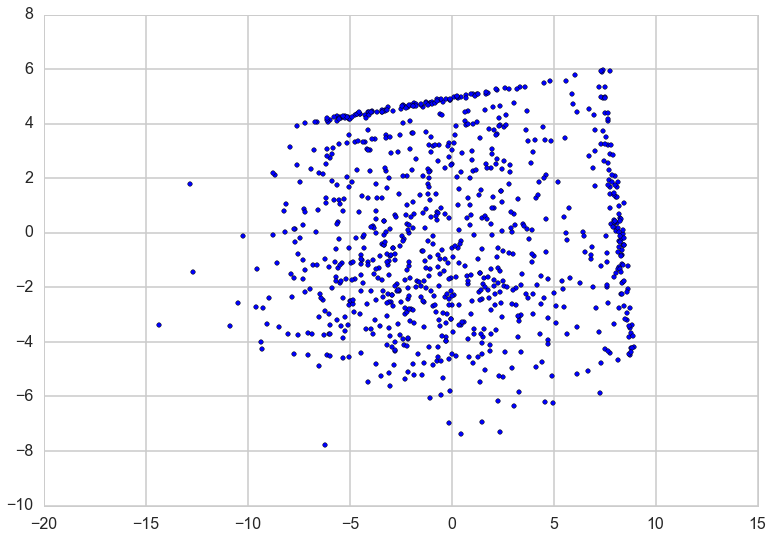

In [176]:
from sklearn.decomposition import PCA
pca = PCA()
temp = pca.fit_transform(all_features_pca[NUMCOLS_SCALED])
plt.scatter([point[0] for point in temp],[point[1] for point in temp])

In [166]:
np.cumsum(pca.explained_variance_ratio_)

array([ 0.65068837,  0.9277291 ,  0.95237937,  0.97471549,  0.98438869,
        0.9891033 ,  0.99154835,  0.99365063,  0.99555393,  0.99716531,
        0.99800281,  0.99866651,  0.99898597,  0.99922694,  0.99941774,
        0.9995687 ,  0.99968889,  0.99979659,  0.99988808,  0.99991367,
        0.99993649,  0.9999552 ,  0.99996688,  0.99997522,  0.99998352,
        0.99998912,  0.999992  ,  0.99999448,  0.99999564,  0.99999663,
        0.99999752,  0.99999821,  0.99999866,  0.99999909,  0.99999949,
        0.99999969,  0.9999998 ,  0.99999989,  0.99999994,  0.99999998,
        0.99999999,  1.        ,  1.        ,  1.        ])

In [167]:
all_features_pca.to_csv('all_features_pca.csv')

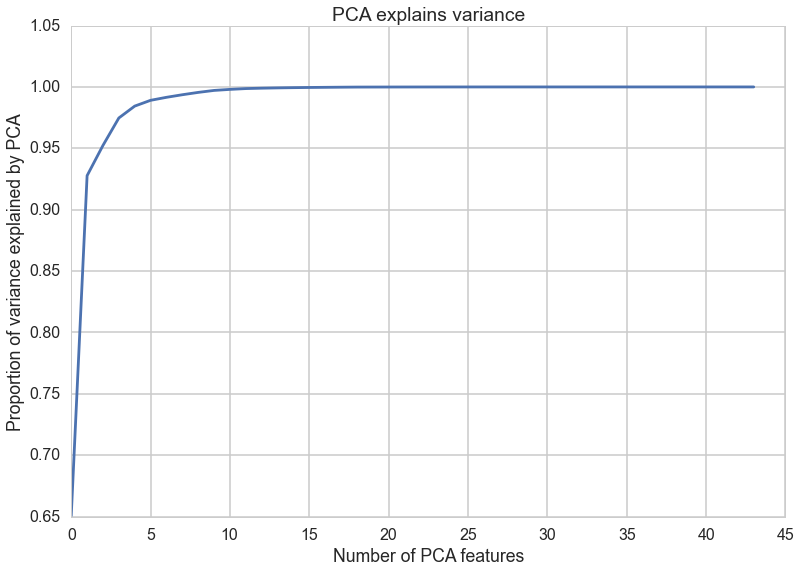

In [168]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of PCA features')
plt.ylabel('Proportion of variance explained by PCA')
plt.title('PCA explains variance')

After standardizing, 3 features explains 95% of the variance! 5 features explain 98% of the variance.

## Support Vector Regression

In [170]:
itrain, itest = train_test_split(xrange(all_features.shape[0]), train_size=0.9)
mask=np.ones(all_features.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask=(mask==1)
df_train = all_features[mask]
df_test = all_features[~mask]

We can see that some features are (quite intuitively) correlated. For example, below we see that log total likes and log total retweets have an approximate linear relationship. This is intuitively plausible. A popular tweet will get a lot of likes and a lot of retweets at the same time, and numbers of likes and retweets are often exponential, so we take logs.

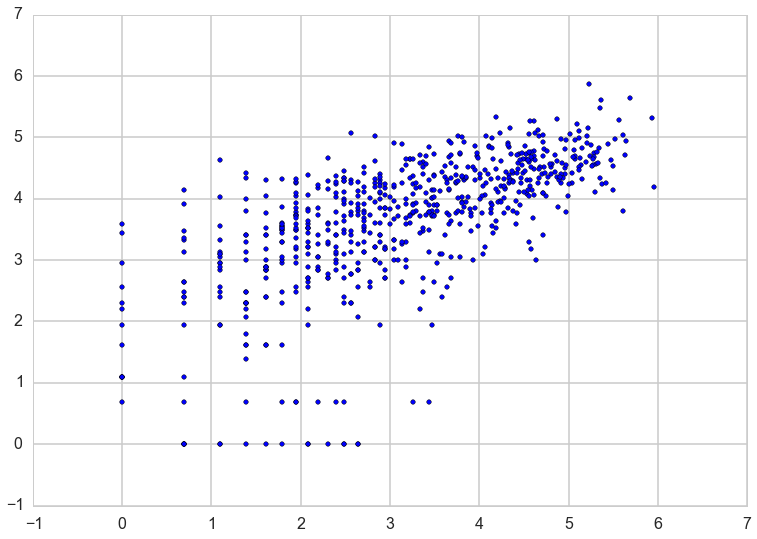

In [171]:
plt.scatter(np.log(df_train['Total_Likes']), np.log(df_train['Total_Retweets']))

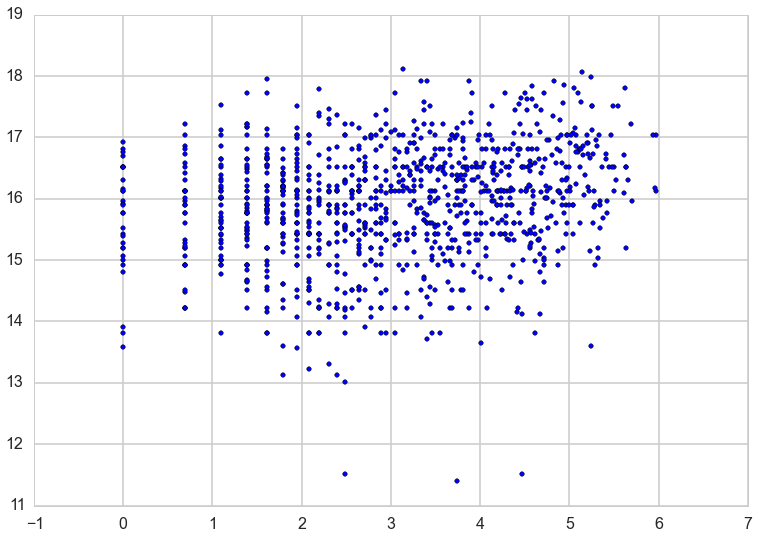

In [68]:
plt.scatter(np.log(df_train['Total_Likes']), np.log(df_train['Series_Amount']))

In [277]:
def get_rmse(s, s_predict):
    s, s_predict = pd.Series(s), pd.Series(s_predict)
    # if some contain na, remove the corresponding value from both
    #mask = [~x for x in (np.isnan(s) or np.isnan(s_predict))]
    #mask = [~(np.isnan(s[i]) or np.isnan(s_predict[i])) for i in range(len(s))]
    #s, s_predict = s[mask], s_predict[mask]
    
    s, s_predict = np.array(s), np.array(s_predict)
    diff = s - s_predict
    return np.sqrt(np.dot(diff,diff)/diff.shape[0])

In [117]:
from sklearn import cross_validation, datasets, svm

In [178]:
# standardize the training set and the testing set separately
for df in [df_train, df_test]:
    for col in NUMCOLS_NOFUNDING:
        # all_features[col + '_scaled'] = (all_features[col] - np.mean(all_features[col]))/np.std(all_features[col])
        df[col + '_scaled'] = boxcox(df[col]+1)[0]
    df['Series_Amount_scaled'] = np.log(df['Series_Amount'])

/Users/Jerry/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Jerry/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [187]:
svr_rbf = SVR(kernel='rbf')
svr_lin = SVR(kernel='linear')
svr_poly = SVR(kernel='poly')


In [189]:
Cs = [0.01, 0.1, 1, 10, 100]
gammas = [0.01, 0.1, 1, 10, 100]
degrees = [1, 2, 3, 4]

In [181]:
X_train = df_train[NUMCOLS_SCALED_NOFUNDING]
X_test = df_test[NUMCOLS_SCALED_NOFUNDING]
y_train = df_train['Series_Amount_scaled']
y_test = df_test['Series_Amount_scaled']

In [190]:
from sklearn.grid_search import GridSearchCV


gs_rbf=GridSearchCV(svr_rbf, param_grid={'C':Cs,'gamma':gammas}, cv=5)
gs_lin=GridSearchCV(svr_lin, param_grid={'C':Cs}, cv=5)
gs_poly=GridSearchCV(svr_poly, param_grid={'C':Cs, 'degree':degrees})

gs_rbf.fit(X_train, y_train)
gs_lin.fit(X_train, y_train)
gs_poly.fit(X_train, y_train)
#print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_

GridSearchCV(cv=None, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.0,
  kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'C': [0.01, 0.1, 1, 10, 100], 'degree': [1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

In [192]:
print "gs_rbf.best_params_ ", gs_rbf.best_params_
print "gs_lin.best_params_ ", gs_lin.best_params_
print "gs_poly.best_params_ ", gs_poly.best_params_

gs_rbf.best_params_  {'C': 10, 'gamma': 0.01}
gs_lin.best_params_  {'C': 1}
gs_poly.best_params_  {'C': 100, 'degree': 1}


In [213]:
gs_rbf.predict(X_train)

array([ 16.42392734,  16.13482726,  15.73491422,  15.62219266,
        16.00902313,  15.41682225,  15.87571084,  15.55000679,
        16.05913564,  15.75583737,  15.5700059 ,  15.71707676,
        15.87491272,  15.95041167,  16.25828036,  15.83459267,
        16.25246874,  16.15977667,  16.20061949,  15.75921748,
        15.6193653 ,  15.9818431 ,  15.87808026,  15.92081446,
        16.03684845,  16.00783267,  15.74418754,  16.01830779,
        16.26419936,  15.91758845,  15.6300385 ,  15.30222045,
        15.9926313 ,  16.2636033 ,  15.27609043,  15.82840104,
        15.78941076,  15.95630809,  15.73452789,  15.87105583,
        15.66326568,  16.12798609,  15.55377899,  16.11311285,
        15.6754559 ,  16.18068293,  15.34232027,  15.60266259,
        16.21412329,  15.59488495,  15.9169789 ,  16.28952961,
        16.17247099,  15.79699952,  15.99731548,  15.58028498,
        16.11929043,  16.21771526,  15.60082096,  16.24284773,
        16.03952563,  16.25560313,  15.31300612,  16.21

In [224]:
X_test.head()

,Total_Likes_scaled,Total_Retweets_scaled,tweet_count_scaled,get_dayrange_scaled,get_dayiqr_scaled,likes_mean_scaled,retweets_mean_scaled,persontag_count_mean_scaled,hashtag_count_mean_scaled,text_length_mean_scaled,persontags_count_mean_scaled,hashtags_count_mean_scaled,links_count_mean_scaled,self_mention_mean_scaled,self_tweet_mean_scaled,likes_std_scaled,retweets_std_scaled,persontag_count_std_scaled,hashtag_count_std_scaled,text_length_std_scaled,persontags_count_std_scaled,hashtags_count_std_scaled,links_count_std_scaled,self_mention_std_scaled,self_tweet_std_scaled,is_Biotechnology_scaled,is_Software_scaled,is_Health Care_scaled,is_Enterprise Software_scaled,is_Clean Technology_scaled,is_Hardware + Software_scaled,is_Semiconductors_scaled,is_Curated Web_scaled,is_Mobile_scaled,is_Web Hosting_scaled,is_Series_A_scaled,is_Series_B_scaled,is_Series_C_scaled,is_Series_D_scaled,mean_neg_scaled,mean_pos_scaled,total_neg_scaled,total_pos_scaled
3,4.432734,5.752718,26.625710,5.805419,4.633981,0.292500,0.253050,0.274277,0.346093,1736.017782,0.227211,0.295587,0.592893,0.021304,0.000000,0.693602,0.778381,0.465541,1.076974,2.038990,0.427541,0.933510,6.382864,0.150006,0.000000,0,0.00000,0,0,0,0,0,0,0,0,0.000000,0.000000,0.119962,0.000000,0.021992,0.041258,0.026165,0.052250
9,2.613959,2.841977,26.105419,7.566951,5.661408,0.057734,0.034254,0.534287,0.318839,844.580505,0.521912,0.305611,0.396103,0.129055,0.077588,0.215794,0.287681,0.596097,1.078410,1.877064,0.603662,1.035930,5.849104,0.453275,0.257054,0,0.00000,0,0,0,0,0,0,0,0,0.313099,0.000000,0.000000,0.000000,0.015075,0.047130,0.000000,0.070410
15,2.297729,2.841977,27.474258,8.302448,6.889123,0.040003,0.031387,0.281545,0.491362,1017.808185,0.269323,0.471796,0.542439,0.094370,0.053260,0.179767,0.152863,0.405155,1.667388,1.842971,0.406958,1.620006,7.258591,0.357110,0.209766,0,0.00000,0,0,0,0,0,0,0,0,0.000000,0.371851,0.000000,0.000000,0.020515,0.041808,0.025615,0.053298
37,2.169315,7.834774,27.390407,7.575275,5.527265,0.035563,0.165218,0.635489,0.414828,1022.616939,0.613243,0.401279,0.614095,0.142178,0.092383,0.173237,0.338859,0.723501,1.096557,1.858270,0.733558,1.073515,4.804314,0.487521,0.285563,0,0.00000,0,0,0,0,0,0,0,0,0.313099,0.000000,0.000000,0.000000,0.015840,0.036269,0.000000,0.028280
89,2.613959,0.000000,30.283793,0.722011,0.718662,0.045566,0.000000,0.035515,0.009093,1074.831252,0.031164,0.009088,0.301868,0.000000,0.000000,0.185311,0.000000,0.177749,0.096299,1.794330,0.170867,0.096062,4.709488,0.000000,0.000000,0,0.02363,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.063024,0.023917,0.048828,0.000000,0.000000


In [225]:
X_train.head()


,Total_Likes_scaled,Total_Retweets_scaled,tweet_count_scaled,get_dayrange_scaled,get_dayiqr_scaled,likes_mean_scaled,retweets_mean_scaled,persontag_count_mean_scaled,hashtag_count_mean_scaled,text_length_mean_scaled,persontags_count_mean_scaled,hashtags_count_mean_scaled,links_count_mean_scaled,self_mention_mean_scaled,self_tweet_mean_scaled,likes_std_scaled,retweets_std_scaled,persontag_count_std_scaled,hashtag_count_std_scaled,text_length_std_scaled,persontags_count_std_scaled,hashtags_count_std_scaled,links_count_std_scaled,self_mention_std_scaled,self_tweet_std_scaled,is_Biotechnology_scaled,is_Software_scaled,is_Health Care_scaled,is_Enterprise Software_scaled,is_Clean Technology_scaled,is_Hardware + Software_scaled,is_Semiconductors_scaled,is_Curated Web_scaled,is_Mobile_scaled,is_Web Hosting_scaled,is_Series_A_scaled,is_Series_B_scaled,is_Series_C_scaled,is_Series_D_scaled,mean_neg_scaled,mean_pos_scaled,total_neg_scaled,total_pos_scaled
0,5.422687,14.741323,0.096324,2.911206,2.155795,0.274243,0.443277,0.517449,0.454443,8.183158,0.500759,0.448112,0.816053,0.129265,0.074286,0.610462,0.977022,0.577672,1.125975,1.624988,0.571700,1.161378,1.262260,0.403078,0.239699,0,0,0,0,0,0.000000,0.011377,0,0,0,0.000000,0.000000,0.150087,0,0.023961,0.041405,0.009414,0.056048
2,2.767462,6.275406,0.096324,0.711033,0.701496,0.075573,0.117137,0.383135,0.508888,9.071426,0.364722,0.499001,0.885821,0.098017,0.038065,0.238901,0.410440,0.491949,0.781449,1.641674,0.470291,0.787708,0.593566,0.320342,0.168247,0,0,0,0,0,0.000000,0.000000,0,0,0,0.000000,0.556594,0.000000,0,0.015294,0.032708,0.005783,0.006128
4,1.097807,6.950739,0.096324,6.816066,5.317859,0.011014,0.128627,0.387629,0.294836,7.716782,0.370295,0.290577,0.564056,0.126078,0.039098,0.093254,0.324708,0.517098,0.598443,1.600951,0.514975,0.604569,1.760171,0.385559,0.170404,0,0,0,0,0,0.010502,0.000000,0,0,0,0.000000,0.556594,0.000000,0,0.016283,0.028184,0.000000,0.000000
5,3.751769,8.625907,0.096324,4.475406,3.404279,0.132073,0.178522,0.409848,0.305785,7.620685,0.383160,0.285832,0.180038,0.070146,0.000000,0.319261,0.541985,0.477203,0.809266,1.704335,0.461583,0.774228,0.910858,0.260007,0.000000,0,0,0,0,0,0.000000,0.000000,0,0,0,0.204031,0.000000,0.000000,0,0.021820,0.041952,0.012949,0.067971
6,3.038341,8.916702,0.096324,3.349588,2.396448,0.249931,0.370094,0.641430,0.164334,7.864373,0.617029,0.147121,0.869439,0.061210,0.057875,0.612825,0.879503,0.670633,0.419140,1.583933,0.660200,0.403277,0.960989,0.240862,0.207739,0,0,0,0,0,0.000000,0.000000,0,0,0,0.000000,0.556594,0.000000,0,0.016712,0.044664,0.011911,0.080615


In [223]:
gs_rbf.predict(X_train.iloc[0:4])

array([ 16.42392734,  16.13482726,  15.73491422,  15.62219266])

In [200]:
svr_rbf_best = gs_rbf.best_estimator_
svr_lin_best = gs_lin.best_estimator_
svr_poly_best = gs_poly.best_estimator_

In [205]:
svr_rbf_best.fit(X_train, y_train)

SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [268]:
print (gs_rbf.score(X_test, y_test), gs_lin.score(X_test, y_test), gs_poly.score(X_test, y_test))

(-8.7055461087226504e-05, -96.850920546113073, -908.66624082071246)


In [278]:
get_rmse([1,1,1],[3,-2,2])

2.0

In [272]:
len(gs_rbf.predict(X_test))

88

AttributeError: 'Series' object has no attribute 'isnan'

In [279]:
get_rmse(gs_rbf.predict(X_test), y_test)

1.0987195854257799

In [280]:
print (get_rmse(gs_rbf.predict(X_test), y_test), get_rmse(gs_lin.predict(X_test), y_test), 
       get_rmse(gs_poly.predict(X_test), y_test))

(1.0987195854257799, 10.868019800730378, 33.136680621398973)


In [210]:
X_test.head()

,Total_Likes_scaled,Total_Retweets_scaled,tweet_count_scaled,get_dayrange_scaled,get_dayiqr_scaled,likes_mean_scaled,retweets_mean_scaled,persontag_count_mean_scaled,hashtag_count_mean_scaled,text_length_mean_scaled,persontags_count_mean_scaled,hashtags_count_mean_scaled,links_count_mean_scaled,self_mention_mean_scaled,self_tweet_mean_scaled,likes_std_scaled,retweets_std_scaled,persontag_count_std_scaled,hashtag_count_std_scaled,text_length_std_scaled,persontags_count_std_scaled,hashtags_count_std_scaled,links_count_std_scaled,self_mention_std_scaled,self_tweet_std_scaled,is_Biotechnology_scaled,is_Software_scaled,is_Health Care_scaled,is_Enterprise Software_scaled,is_Clean Technology_scaled,is_Hardware + Software_scaled,is_Semiconductors_scaled,is_Curated Web_scaled,is_Mobile_scaled,is_Web Hosting_scaled,is_Series_A_scaled,is_Series_B_scaled,is_Series_C_scaled,is_Series_D_scaled,mean_neg_scaled,mean_pos_scaled,total_neg_scaled,total_pos_scaled
3,4.432734,5.752718,26.625710,5.805419,4.633981,0.292500,0.253050,0.274277,0.346093,1736.017782,0.227211,0.295587,0.592893,0.021304,0.000000,0.693602,0.778381,0.465541,1.076974,2.038990,0.427541,0.933510,6.382864,0.150006,0.000000,0,0.00000,0,0,0,0,0,0,0,0,0.000000,0.000000,0.119962,0.000000,0.021992,0.041258,0.026165,0.052250
9,2.613959,2.841977,26.105419,7.566951,5.661408,0.057734,0.034254,0.534287,0.318839,844.580505,0.521912,0.305611,0.396103,0.129055,0.077588,0.215794,0.287681,0.596097,1.078410,1.877064,0.603662,1.035930,5.849104,0.453275,0.257054,0,0.00000,0,0,0,0,0,0,0,0,0.313099,0.000000,0.000000,0.000000,0.015075,0.047130,0.000000,0.070410
15,2.297729,2.841977,27.474258,8.302448,6.889123,0.040003,0.031387,0.281545,0.491362,1017.808185,0.269323,0.471796,0.542439,0.094370,0.053260,0.179767,0.152863,0.405155,1.667388,1.842971,0.406958,1.620006,7.258591,0.357110,0.209766,0,0.00000,0,0,0,0,0,0,0,0,0.000000,0.371851,0.000000,0.000000,0.020515,0.041808,0.025615,0.053298
37,2.169315,7.834774,27.390407,7.575275,5.527265,0.035563,0.165218,0.635489,0.414828,1022.616939,0.613243,0.401279,0.614095,0.142178,0.092383,0.173237,0.338859,0.723501,1.096557,1.858270,0.733558,1.073515,4.804314,0.487521,0.285563,0,0.00000,0,0,0,0,0,0,0,0,0.313099,0.000000,0.000000,0.000000,0.015840,0.036269,0.000000,0.028280
89,2.613959,0.000000,30.283793,0.722011,0.718662,0.045566,0.000000,0.035515,0.009093,1074.831252,0.031164,0.009088,0.301868,0.000000,0.000000,0.185311,0.000000,0.177749,0.096299,1.794330,0.170867,0.096062,4.709488,0.000000,0.000000,0,0.02363,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.063024,0.023917,0.048828,0.000000,0.000000


In [211]:
svr_rbf_best.predict(X_test)

array([ 15.70958099,  15.70958099,  15.70958099,  15.70958099,
        15.70958099,  15.70958099,  15.70958099,  15.70958099,
        15.70958099,  15.70958099,  15.70958099,  15.70958099,
        15.70958099,  15.70958099,  15.70958099,  15.70958099,
        15.70958099,  15.70958099,  15.70958099,  15.70958099,
        15.70958099,  15.70958099,  15.70958099,  15.70958099,
        15.70958099,  15.70958099,  15.70958099,  15.70958099,
        15.70958099,  15.70958099,  15.70958099,  15.70958099,
        15.70958099,  15.70958099,  15.70958099,  15.70958099,
        15.70958099,  15.70958099,  15.70958099,  15.70958099,
        15.70958099,  15.70958099,  15.70958099,  15.70958099,
        15.70958099,  15.70958099,  15.70958099,  15.70958099,
        15.70958099,  15.70958099,  15.70958099,  15.70958099,
        15.70958099,  15.70958099,  15.70958099,  15.70958099,
        15.70958099,  15.70958099,  15.70958099,  15.70958099,
        15.70958099,  15.70958099,  15.70958099,  15.70

In [128]:
train_df.head()

,company_name,Series,Total_Likes,Total_Retweets,Series_Amount,Market,tweet_count,get_dayrange,get_dayiqr,likes_mean,retweets_mean,persontag_count_mean,hashtag_count_mean,text_length_mean,persontags_count_mean,hashtags_count_mean,links_count_mean,self_mention_mean,self_tweet_mean,likes_std,retweets_std,persontag_count_std,hashtag_count_std,text_length_std,persontags_count_std,hashtags_count_std,links_count_std,self_mention_std,self_tweet_std,is_Biotechnology,is_Software,is_Health Care,is_Enterprise Software,is_Clean Technology,is_Hardware + Software,is_Semiconductors,is_Curated Web,is_Mobile,is_Web Hosting,is_Series_A,is_Series_B,is_Series_C,is_Series_D,mean_neg,mean_pos,total_neg,total_pos,Total_Likes_scaled,Total_Retweets_scaled,Series_Amount_scaled,tweet_count_scaled,get_dayrange_scaled,get_dayiqr_scaled,likes_mean_scaled,retweets_mean_scaled,persontag_count_mean_scaled,hashtag_count_mean_scaled,text_length_mean_scaled,persontags_count_mean_scaled,hashtags_count_mean_scaled,links_count_mean_scaled,self_mention_mean_scaled,self_tweet_mean_scaled,likes_std_scaled,retweets_std_scaled,persontag_count_std_scaled,hashtag_count_std_scaled,text_length_std_scaled,persontags_count_std_scaled,hashtags_count_std_scaled,links_count_std_scaled,self_mention_std_scaled,self_tweet_std_scaled,is_Biotechnology_scaled,is_Software_scaled,is_Health Care_scaled,is_Enterprise Software_scaled,is_Clean Technology_scaled,is_Hardware + Software_scaled,is_Semiconductors_scaled,is_Curated Web_scaled,is_Mobile_scaled,is_Web Hosting_scaled,is_Series_A_scaled,is_Series_B_scaled,is_Series_C_scaled,is_Series_D_scaled,mean_neg_scaled,mean_pos_scaled,total_neg_scaled,total_pos_scaled
0,1stdibs,_Series_C,230,134,15000000,Semiconductors,213,13,7,1.863850,1.521127,0.957746,1.098592,130.516432,0.934272,1.093897,0.840376,0.436620,0.145540,5.780192,7.009816,1.087276,1.882052,38.451464,1.079570,1.876018,0.458529,0.515763,0.353475,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0.038290,0.068850,0.010989,0.082418,3.056221,1.781717,0.315671,1.037473,-0.472859,-0.481194,3.466300,2.956161,0.406746,2.155423,1.462267,0.463171,2.219277,1.395483,1.988879,1.285646,2.098005,2.278160,0.188147,3.079391,0.053778,0.221091,3.127493,-0.049940,1.666105,1.245820,-0.1392,-0.170034,-0.122885,-0.153911,-0.081582,-0.108193,8.638576,-0.122885,-0.049855,-0.081582,-0.607271,-0.843479,1.843909,-0.309862,0.314415,0.601017,-0.384478,0.367385
2,365Scores,_Series_B,15,23,5500000,Apps,163,1,1,0.092025,0.141104,0.582822,1.515337,181.895706,0.552147,1.490798,0.914110,0.184049,0.049080,0.348007,0.656189,0.822642,1.113086,43.445668,0.771029,1.090747,0.302230,0.388718,0.216700,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.019701,0.046836,0.006329,0.006329,-0.502758,-0.614542,-0.594887,-1.320598,-0.536470,-0.558936,-0.469365,-0.557887,-0.327665,3.447338,4.766770,-0.310045,3.473511,1.700951,0.399670,-0.121193,-0.314745,-0.290861,-0.372053,0.999147,0.605471,-0.425569,0.983834,-1.978421,0.917290,0.368419,-0.1392,-0.170034,-0.122885,-0.153911,-0.081582,-0.108193,-0.115760,-0.122885,-0.049855,-0.081582,-0.607271,1.185566,-0.542326,-0.309862,-0.794275,-0.401062,-0.540275,-1.077705
3,36Kr,_Series_C,58,21,20000,Startups,173,83,43,1.312139,0.393064,0.364162,0.520231,149.664740,0.289017,0.427746,0.630058,0.023121,0.000000,12.936146,2.761100,0.792618,1.009200,85.569792,0.680070,0.896851,0.518964,0.150725,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.036364,0.058589,0.051546,0.077320,0.209038,-0.657718,-1.120136,-0.848983,-0.101795,-0.014745,2.240813,0.083695,-0.755981,0.362503,2.693807,-0.842478,0.114193,0.524178,-0.612910,-0.837005,5.276380,0.560237,-0.435611,0.718108,5.258781,-0.616207,0.454530,0.695731,-0.485471,-1.021699,-0.1392,-0.170034,-0.122885,-0.153911,-0.081582,-0.108193,-0.115760,-0.122885,-0.049855,-0.081582,-0.607271,-0.843479,1.843909,-0.309862,0.199553,0.133949,0.971495,0.270563
4,6fusion,_Series_B,2,28,7000000,Hardware + Software,177,251,131,0.011299,0.158192,0.593220,0.468927,108.621469,0.564972,0.463277,0.576271,0.384181,0.050847,0.105996

In [ ]:
svr_rbf = SVR(kernel='rbf')
from sklearn.grid_search import GridSearchCV
gs=GridSearchCV(clfsvm, param_grid={'C':Cs}, cv=5)
gs.fit(Xmatrix_train, Yresp_train)
print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_

/Users/Jerry/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


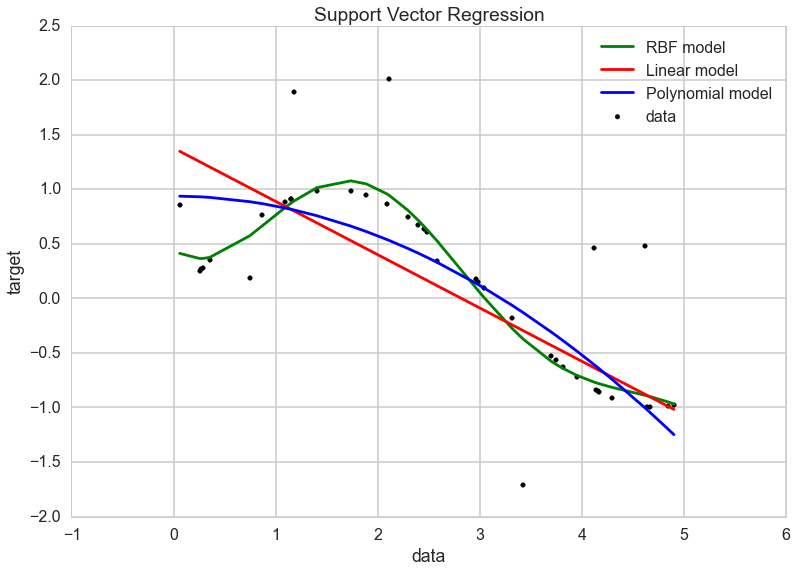

In [18]:
###############################################################################
# Generate sample data
X = np.sort(5 * np.random.rand(40, 1), axis=0)
y = np.sin(X).ravel()

###############################################################################
# Add noise to targets
y[::5] += 3 * (0.5 - np.random.rand(8))

###############################################################################
# Fit regression model
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_lin = SVR(kernel='linear', C=1e3)
svr_poly = SVR(kernel='poly', C=1e3, degree=2)
y_rbf = svr_rbf.fit(X, y).predict(X)
y_lin = svr_lin.fit(X, y).predict(X)
y_poly = svr_poly.fit(X, y).predict(X)

###############################################################################
# look at the results
plt.scatter(X, y, c='k', label='data')
plt.hold('on')
plt.plot(X, y_rbf, c='g', label='RBF model')
plt.plot(X, y_lin, c='r', label='Linear model')
plt.plot(X, y_poly, c='b', label='Polynomial model')
plt.xlabel('data')
plt.ylabel('target')
plt.title('Support Vector Regression')
plt.legend()
plt.show()